In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import re

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')


In [2]:
class consts:
    c = 3e8
    e = 1.6e-19

    m_e = 9.1e-31           # kg
    h = 6.626e-34      # J * s
    hbar = 1.054e-34  # J * s
class setup:
    dummy = 0


### Dynamic

In [35]:
V_max = 3.2
V_min = 7.2

def get_l_U0(V_max, V_min, V_max_err = 0, V_min_err = 0):
    l = consts.h * np.sqrt(5/32) / np.sqrt(consts.m_e * consts.e * (V_min - V_max))
    l_err = l * np.sqrt((V_max_err / V_max)**2 + (V_min_err / V_min)**2)
    print(f"l = ({l * 1e10:.1f} +- {l_err * 1e10:.2f}) Angstrem")

    U0 = 4/5 * V_min - 9/5 * V_max
    print(f"U0 = {U0} eV")

    return l, U0

# Расчет дает U0 = 0 из-за контактной разности потенциалов
l, U0 = get_l_U0(V_max, V_min)


l = (3.4 +- 0.00) Angstrem
U0 = 0.0 eV


### Static

In [36]:
R = 100 # kOm

def get_data(filename):
    data = pd.read_csv(filename)
    fmt = {
        'V_ks(V)' : 'V_k',
        'V_a(mV)' : 'V_a',
    }

    data = mipt.map_excel(data, fmt)
    data['I'] = data['V_a'] / 100 # mkA
    return data

data1 = get_data('data/2.8V.csv')
data2 = get_data('data/3.3V.csv')

data2


,V_k,V_a,I
0,0.250,0.00,0.0000
1,0.500,0.00,0.0000
2,0.756,0.00,0.0000
3,0.992,0.00,0.0000
4,1.251,0.11,0.0011
5,1.507,1.64,0.0164
6,1.580,3.37,0.0337
7,1.640,5.93,0.0593
8,1.718,11.50,0.1150
9,1.780,18.55,0.1855


$V_{накала} = 2.8$ В
V_max = 2.546 V, V_min = 7.502 V
I_max = 0.4816 mkA, I_min = 0.2335 mkA
l = (3.1 +- 0.15) Angstrem
U0 = 1.4188 eV
$V_{накала} = 3.3$ В
V_max = 2.563 V, V_min = 3.394 V
I_max = 0.9658 mkA, I_min = 0.9311 mkA


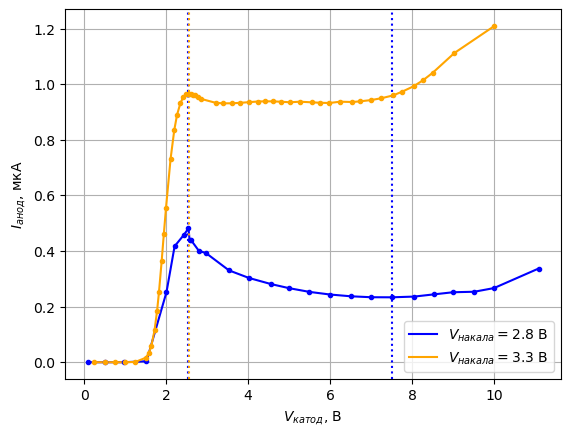

In [37]:
def process(data, label, color, drawmax=True, drawmin=True):
    print(label)
    x = np.array(data['V_k']) # V
    y = np.array(data['I'])   # mkA
    mipt.plot(x, y, func=None, color=color)

    plt.plot(x, y, label=label, c = color)

    maxV = np.argmax(y[:len(y)//2])
    minV = np.argmin(y[len(y)//2:]) + len(y)//2
    if drawmax: plt.axvline(x[maxV], linestyle=':', c=color)
    if drawmin: plt.axvline(x[minV], linestyle=':', c=color)

    print(f"V_max = {x[maxV]} V, V_min = {x[minV]} V")
    print(f"I_max = {y[maxV]} mkA, I_min = {y[minV]} mkA")

    return x[maxV], x[minV]

V_max, V_min = process(data1, "$V_{накала} = 2.8$ В", 'blue')
V_max_err = 0.1
V_min_err = 0.2
l, U0 = get_l_U0(V_max, V_min, V_max_err, V_min_err)

process(data2, "$V_{накала} = 3.3$ В", 'orange', drawmin=False)

plt.xlabel(r'$V_{катод}$, В')
plt.ylabel(r'$I_{анод}$, мкА')
plt.legend()
plt.grid()
plt.savefig('gen/static.pdf')


In [41]:
E_n = lambda n: n**2 * consts.h**2 / (8 * consts.m_e * l**2) / consts.e - U0
print(f"{E_n(1)=}")
print(f"{E_n(1.5)=}")
print(f"{E_n(2)=}")


E_n(1)=2.545999999999999
E_n(1.5)=7.501999999999998
E_n(2)=14.440399999999997


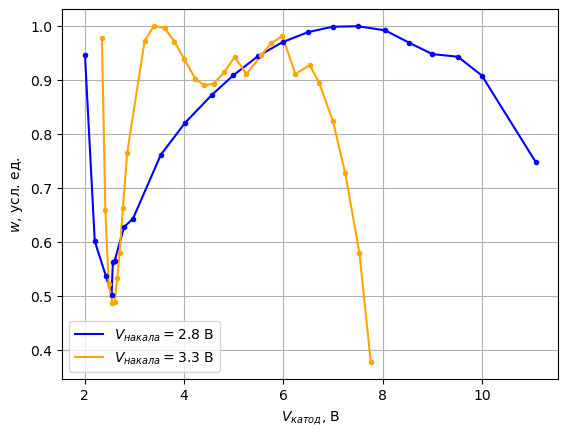

In [40]:
def probability(data, label, color, start, end=None):
    x = np.array(data['V_k'])
    y = np.array(data['I'])
    if end == None: end = len(x)
    x = np.array(x[start:end])    # V
    y = -np.log(y[start:end])
    y = y / max(y)

    mipt.plot(x, y, func=None, color=color)
    plt.plot(x, y, label=label, c = color)
    return None

probability(data1, "$V_{накала} = 2.8$ В", 'blue', start=4)
probability(data2, "$V_{накала} = 3.3$ В", 'orange', start=17, end=-5)
plt.legend()
plt.grid()
plt.xlabel(r'$V_{катод}$, В')
plt.ylabel(r'$w$, усл. ед.')
plt.savefig(f'gen/probability.pdf')
plt.show()


In [ ]:
keys = [ 'Серия 0', 'Серия 1', 'Серия 2']
data = pd.concat([series0, series1, series2], axis=1, keys=keys)
# display(data)

fmt = {
    (ser, 'lambda') : [r'$\lambda$, нм', '{:.1f}'] for ser in keys
}
fmt2 = {
    (ser, 'd_lambda') : [r'$\Delta \lambda$, нм', '{:.1f}'] for ser in keys
}
fmt.update(fmt2)

table = mipt.table(data, fmt)
table.to_latex('gen/series.tex', na_rep='')
table.rename().get_data()


In [51]:
keys=[r'$V_{\text{накала}} = 2.8$ В', r'$V_{\text{накала}} = 3.3$ В']
d = pd.concat([data1, data2], axis='columns', keys=keys)
# display(d)

fmt = {(key, 'V_k') : [r'$V_{\text{катод}}$, В',  '{:.3f}'] for key in keys} \
    | {(key, 'V_a') : [r'$V_{\text{анод}}$, мВ',  '{:.2f}'] for key in keys} \
    | {(key, 'I')   : [r'$I_{\text{анод}}$, мкА', '{:.4f}'] for key in keys}

# display(fmt)
table = mipt.table(d, fmt)
table.to_latex('gen/data.tex', na_rep='')
table.rename().get_data()


$V_{\text{накала}} = 2.8$ В                                               \
         $V_{\text{катод}}$, В $V_{\text{анод}}$, мВ $I_{\text{анод}}$, мкА   
0                        0.085                  0.00                 0.0000   
1                        0.503                  0.00                 0.0000   
2                        0.966                  0.00                 0.0000   
3                        1.521                  0.36                 0.0036   
4                        2.009                 25.22                 0.2522   
5                        2.207                 41.70                 0.4170   
6                        2.434                 45.82                 0.4582   
7                        2.546                 48.16                 0.4816   
8                        2.571                 44.07                 0.4407   
9                        2.605                 43.98                 0.4398   
10                       2.797                 40.10                 0.4010   
11                       2.976                 39.22                 0.3922   
12                       3.534                 33.03                 0.3303   
13                       4.023                 30.30                 0.3030   
14                       4.560                 28.11                 0.2811   
15                       4.996                 26.65                 0.2665   
16                       5.497                 25.30                 0.2530   
17                       5.995                 24.36                 0.2436   
18                       6.504                 23.72                 0.2372   
19                       6.998                 23.38                 0.2338   
20                       7.502                 23.35                 0.2335   
21                       8.053                 23.61                 0.2361   
22                       8.542                 24.42                 0.2442   
23                       9.000                 25.17                 0.2517   
24                       9.518                 25.35                 0.2535   
25                      10.000                 26.67                 0.2667   
26                      11.087                 33.69                 0.3369   
27                         NaN                   NaN                    NaN   
28                         NaN                   NaN                    NaN   
29                         NaN                   NaN                    NaN   
30                         NaN                   NaN                    NaN   
31                         NaN                   NaN                    NaN   
32                         NaN                   NaN                    NaN   
33                         NaN                   NaN                    NaN   
34                         NaN                   NaN                    NaN   
35                         NaN                   NaN                    NaN   
36                         NaN                   NaN                    NaN   
37                         NaN                   NaN                    NaN   
38                         NaN                   NaN                    NaN   
39                         NaN                   NaN                    NaN   
40                         NaN                   NaN                    NaN   
41                         NaN                   NaN                    NaN   
42                         NaN                   NaN                    NaN   
43                         NaN                   NaN                    NaN   
44                         NaN                   NaN                    NaN   
45                         NaN                   NaN                    NaN   
46                         NaN                   NaN                    NaN   
47                         NaN                   NaN                    NaN   
48                         NaN                   NaN 

### Magnets calibration

In [3]:
calibration_data = mipt.read_excel('data/5101.xlsx', usecols=('J', 'K'), header=(0, 1))

fmt = {
    'V_r, mV' : 'V',
    'V_probe, mV' : 'V_probe',
    'Main coils' : 'Calibration'
}

calibration_data = mipt.map_excel(calibration_data, fmt)
calibration_data


Calibration        
             V V_probe
0        11.12    1.36
1        17.58    2.16
2        28.20    3.48
3        35.83    4.46
4        43.02    5.33
5        51.90    6.42
6        59.80    7.39
7        65.80    8.18
8        73.51    9.16
9          NaN     NaN
10         NaN     NaN
11         NaN     NaN
12         NaN     NaN
13         NaN     NaN
14         NaN     NaN
15         NaN     NaN
16         NaN     NaN
17         NaN     NaN
18         NaN     NaN
19         NaN     NaN

In [4]:
V = 0.001 * calibration_data['Calibration', 'V_probe']
S = 1/4 * np.pi * (setup.probe_d / 1000) ** 2
omega = 2 * np.pi * setup.freq
calibration_data['Calibration', 'B'] = 10000 * V / ( setup.probe_N * S * omega) # Gauss

calibration_data


Calibration                   
             V V_probe          B
0        11.12    1.36   5.500865
1        17.58    2.16   8.736668
2        28.20    3.48  14.075743
3        35.83    4.46  18.039602
4        43.02    5.33  21.558538
5        51.90    6.42  25.967319
6        59.80    7.39  29.890731
7        65.80    8.18  33.086086
8        73.51    9.16  37.049945
9          NaN     NaN        NaN
10         NaN     NaN        NaN
11         NaN     NaN        NaN
12         NaN     NaN        NaN
13         NaN     NaN        NaN
14         NaN     NaN        NaN
15         NaN     NaN        NaN
16         NaN     NaN        NaN
17         NaN     NaN        NaN
18         NaN     NaN        NaN
19         NaN     NaN        NaN

,<x>,sx,<y>,sy,rxy,a,da,b,db
0,42.973333,416.122644,21.545055,105.817059,209.834816,0.504262,0.001355,-0.124762,0.064439


4.917857859812961


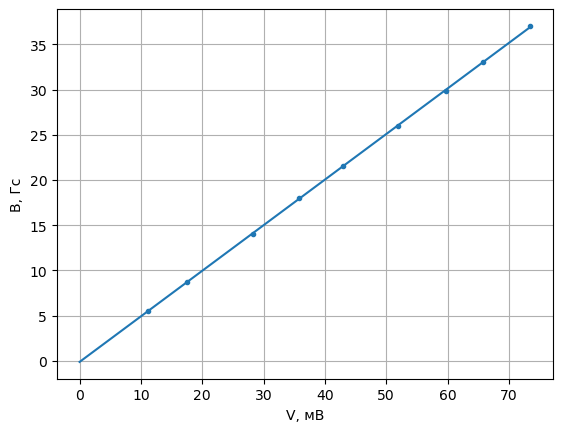

In [5]:
d = calibration_data['Calibration']
x, y, V2B = mipt.plot(d['V'], d['B'], x_min=0)
plt.xlabel('V, мВ')
plt.ylabel('B, Гс')
plt.grid()
plt.savefig('gen/calibration.pdf')

V2B_eps = (2*(setup.probe_d_err/setup.probe_d)**2 + (setup.freq_err/setup.freq)**2)**0.5
mnk = mipt.mnk(x, y).data
display(mnk)
print(V2B(10)) # Sanity check
dV2dB = lambda v: V2B(v) - V2B(0) # for errors and deltas


In [6]:
d = calibration_data['Calibration'].dropna()
display(d)
fmt = {
    'V' : [r'$V$, мВ', '{:.2f}'],
    'V_probe' : [r'$V_{probe}$, мВ', '{:.2f}'],
    'B' : [r'$B$, Гс', '{:.1f}']
}

table = mipt.table(d, fmt)
table.to_latex('gen/calibration.tex')


,V,V_probe,B
0,11.12,1.36,5.500865
1,17.58,2.16,8.736668
2,28.20,3.48,14.075743
3,35.83,4.46,18.039602
4,43.02,5.33,21.558538
5,51.90,6.42,25.967319
6,59.80,7.39,29.890731
7,65.80,8.18,33.086086
8,73.51,9.16,37.049945


### EPR frequency

In [7]:
data = mipt.read_excel('data/5101.xlsx', usecols=('A', 'B', 'C', 'D'), header=(0)).dropna()
fmt = {
    'f, MHz' : 'f',
    'V, mV' : 'V',
    'V_left, mV' : 'V_left',
    'V_right, mV' : 'V_right',
    'Width, 10*cell' : 'width'
}
data = mipt.map_excel(data, fmt)
data


,f,V,V_left,V_right
0,108.895,79.12,88.68,70.14
1,98.663,71.73,81.01,62.47
2,118.613,86.57,95.82,77.32
3,128.767,94.16,103.58,84.74
4,138.597,100.75,109.68,91.14
5,148.547,108.43,117.80,99.21
6,88.697,64.97,74.74,56.22
7,78.504,57.24,67.11,48.15
8,68.514,49.88,59.75,40.32


In [8]:
data['B'] = V2B(data['V'])
data['B_left'] = V2B(data['V_left'])
data['B_right'] = V2B(data['V_right'])
data


,f,V,V_left,V_right,B,B_left,B_right
0,108.895,79.12,88.68,70.14,39.772444,44.593188,35.244171
1,98.663,71.73,81.01,62.47,36.045948,40.725499,31.376482
2,118.613,86.57,95.82,77.32,43.529195,48.193618,38.864772
3,128.767,94.16,103.58,84.74,47.356544,52.106691,42.606396
4,138.597,100.75,109.68,91.14,50.679630,55.182689,45.833672
5,148.547,108.43,117.80,99.21,54.552362,59.277296,49.903066
6,88.697,64.97,74.74,56.22,32.637137,37.563776,28.224845
7,78.504,57.24,67.11,48.15,28.739192,33.716258,24.155451
8,68.514,49.88,59.75,40.32,25.027824,30.004890,20.207080


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,39.815586,90.329276,6.826311e+08,2.636347e+16,1.543079e+09,1.708282e+07,72542.273964,2.468520e+06,2.969461e+06


g = 1.942 +- 0.044
g = 2 (reference)


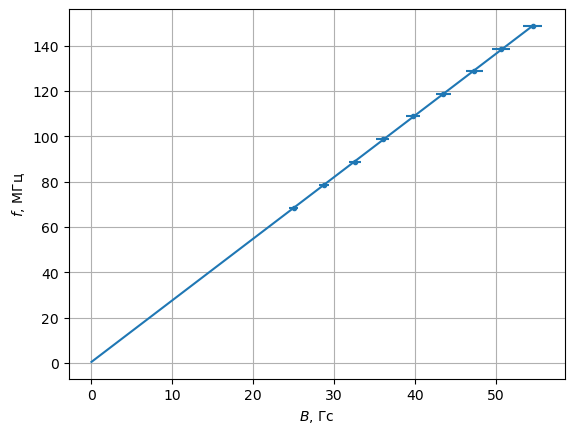

In [9]:
x, y, _ = mipt.plot(data['B'], data['f'], x_min=0, xerr=data['B'] * V2B_eps)
plt.grid()
plt.xlabel('$B$, Гс')
plt.ylabel('$f$, МГц')
plt.savefig('gen/epr.pdf')

mnk = mipt.mnk(x, 2 * np.pi * y * 1e6).data
display(mnk)

a = mnk['a'][0]
a_err = mnk['da'][0]
g = a * consts.hbar / consts.mu_B
g_err = g * ((a_err/a)**2 + V2B_eps**2)**0.5
print(f"g = {g:.3f} +- {g_err:.3f}")
print(f"g = 2 (reference)")


In [10]:
data.sort_values(by='f', ignore_index=True, inplace=True)
display(data)
fmt = {
    'f' : [r'$f$, МГц', '{:.3f}'],
    'V' : [r'$V$, мВ', '{:.2f}'],
    'V_left' : [r'$V_{left}$, мВ', '{:.2f}'],
    'V_right' : [r'$V_{right}$, мВ', '{:.2f}'],
    'B' : [r'$B$, Гс', '{:.1f}'],
    'B_left' : [r'$B_{left}$, Гс', '{:.1f}'],
    'B_right' : [r'$B_{right}$, Гс', '{:.1f}'],
}

table = mipt.table(data, fmt)
table.to_latex('gen/epr.tex')


,f,V,V_left,V_right,B,B_left,B_right
0,68.514,49.88,59.75,40.32,25.027824,30.004890,20.207080
1,78.504,57.24,67.11,48.15,28.739192,33.716258,24.155451
2,88.697,64.97,74.74,56.22,32.637137,37.563776,28.224845
3,98.663,71.73,81.01,62.47,36.045948,40.725499,31.376482
4,108.895,79.12,88.68,70.14,39.772444,44.593188,35.244171
5,118.613,86.57,95.82,77.32,43.529195,48.193618,38.864772
6,128.767,94.16,103.58,84.74,47.356544,52.106691,42.606396
7,138.597,100.75,109.68,91.14,50.679630,55.182689,45.833672
8,148.547,108.43,117.80,99.21,54.552362,59.277296,49.903066


### Peaks width

[2.4885327204733017,
 2.410372118310514,
 2.488532720473298,
 2.291870560192738,
 2.4633196230014356,
 2.2061460287883854,
 2.339775445389286,
 2.3347328258949105,
 2.4103721183105122,
 2.264136152973684,
 2.3322115161477264,
 2.332211516147723,
 2.375073781849899,
 2.375073781849899,
 2.251529604237753,
 2.4229786670464435,
 2.3624672331139642,
 2.324647586906167]

Width = (2.36 +- 0.15) Gauss


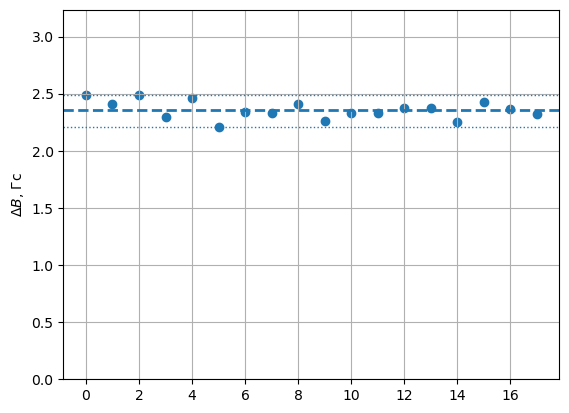

In [11]:
import math
from matplotlib.ticker import FormatStrFormatter, MultipleLocator

width_data = []
for center, left, right in zip(data['B'], data['B_left'], data['B_right']):
    width_data.append((left - center) / 2)    # V_left corresponds to peak shifted left for 2 cells
    width_data.append((center - right) / 2)

display(width_data)

width = np.mean(width_data)
width_min = np.min(width_data)
width_max = np.max(width_data)

plt.scatter(range(0, len(width_data)), width_data)
plt.axhline(y=width, linestyle='--', linewidth=2)
plt.axhline(y=width_min, linestyle=':', linewidth=1)
plt.axhline(y=width_max, linestyle=':', linewidth=1)

ax = plt.gca()
ax.set_ylim([0, max(width_data) * 1.3])
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

plt.ylabel('$\Delta B$, Гс')
plt.grid()
plt.savefig('gen/widths.pdf')

width_err = np.max([width_max - width, width - width_min])
print(f'Width = ({width:.2f} +- {width_err:.2f}) Gauss')


In [12]:
data = mipt.read_excel('data/5101.xlsx', usecols=('A', 'B', 'E'), header=(0)).dropna()
data.reset_index(drop=True, inplace=True)
fmt = {
    'f, MHz' : 'f',
    'V, mV' : 'V',
    'Width, 10*cell' : 'width',
}
data = mipt.map_excel(data, fmt)
data['width'] *= 10  # convert to amount of cells
data['B'] = V2B(data['V'])
data['B_width'] = data['width'] * width
data


,f,V,width,B,B_width
0,108.895,79.12,1.685393,39.772444,3.976965
1,98.663,71.73,1.670588,36.045948,3.94203
2,118.613,86.57,1.697368,43.529195,4.005222
3,128.767,94.16,1.625,47.356544,3.834457
4,88.697,64.97,1.607595,32.637137,3.793387
5,78.504,57.24,1.612903,28.739192,3.805913


In [13]:
mu = g * 1/2 * consts.mu_B
E_width = 2 * mu * data['B_width']
data['tau'] = consts.hbar / E_width
tau = np.mean(data['tau'])
tau_err = tau * ((g_err/g)**2 + (width_err/width)**2)**0.5
print(f'tau: ({tau*1e9:.1f} +- {tau_err*1e9:.1f}) нс')


tau: (15.0 +- 1.0) нс
